In [ ]:
# Import the libraries

import pandas as pd
import spacy
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
from imblearn.over_sampling import RandomOverSampler
import string
string.punctuation
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the data
df = pd.read_csv("/content/drive/MyDrive/IFT_512_Project/Restaurant reviews.csv")

In [ ]:
# Check rows and columns in the data
df.shape

(10000, 8)

In [ ]:
# Check sample data

df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [ ]:
# Drop unwanted columns

df = df.drop(['Time', 'Pictures', '7514'], axis=1)

In [ ]:
df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers"
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers"
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers"
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower"
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers"


In [ ]:
# Get the basic statistics about the data

df.describe()

,Restaurant,Reviewer,Review,Rating,Metadata
count,10000,9962,9955,9962,9962
unique,100,7446,9364,10,2477
top,Beyond Flavours,Parijat Ray,good,5,1 Review
freq,100,13,237,3832,919


In [ ]:
# Remove the irrelevant information in the data: Rating value is 'Like' instead of a number. Removing the row with Rating value as 'Like'.

print(df['Rating'].value_counts())
df = df[df['Rating'] != 'Like']
print("="*50)
print(df['Rating'].value_counts())

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64
5      3832
4      2373
1      1735
3      1193
2       684
4.5      69
3.5      47
2.5      19
1.5       9
Name: Rating, dtype: int64


In [ ]:
# 1. Top-rated restaurants are those Restaurants with more than k(say 70) 5-star ratings out of 100 ratings.

def top_rated_restaurants(df, k):
    """Returns top-rated restaurants in the data"""
    # Grouping the restaurants with all the rating for each restaurant
    df = df.groupby('Restaurant')['Rating'].apply(list).reset_index()
    # Return the restaurants with more than k 5-star rating
    df = df[df['Rating'].apply(lambda x: x.count('5')) > k]
    return df['Restaurant'].to_list()

print(top_rated_restaurants(df, 70))

["3B's - Buddies, Bar & Barbecue", "AB's - Absolute Barbecues", 'B-Dubs', 'Flechazo', 'Paradise', 'The Indi Grill']


In [ ]:
# 2. Overall sentiment of reviews for each restaurant: Given a restaurant, we calculate the average and median of ratings for each restaurant.

def overall_sentiment(df, restaurant_name):
    """Returns overall sentiment for a specific restaurant"""
    # Converting the 'Rating' column values to numeric
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    # Computing the average and median of ratings for each restaurant
    df = df.groupby('Restaurant')['Rating'].agg(['mean', 'median']).reset_index()
    # Return average and median of Ratings for a specific restaurant
    result_dict = {
        "Average": df[df['Restaurant'] == restaurant_name]['mean'][1],
        "Median": df[df['Restaurant'] == restaurant_name]['median'][1]
    }
    return json.dumps(result_dict)

overall_sentiment(df, "13 Dhaba")

'{"Average": 3.48, "Median": 4.0}'

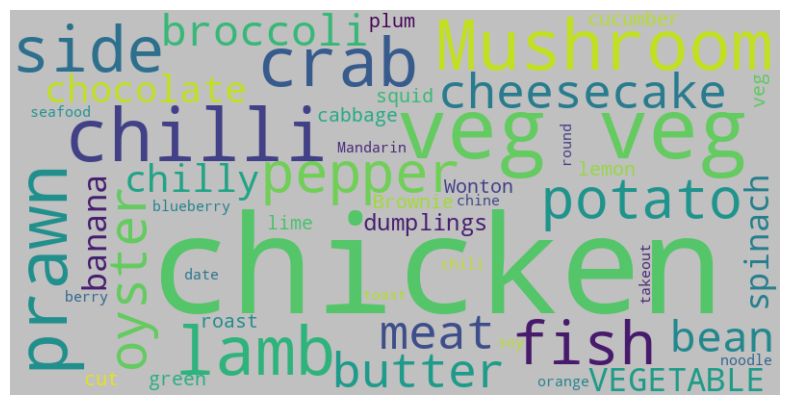

In [ ]:
# 3. Popular menu items in a specific restaurant

def get_all_food_items():
    """Get all the food item keywords"""
    food = wn.synset('food.n.02')
    food_items_all = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
    return food_items_all

def get_popular_foods(text, food_item_keywords):
    """Get all the food items from the input text"""
    # Load the spaCy model for English
    nlp = spacy.load("en_core_web_sm")
    # Process the input text using spaCy
    doc = nlp(text)
    # Extract food items based on keywords
    food_keywords = food_item_keywords
    food_items = [token.text for token in doc if token.text.lower() in food_keywords]
    return " ".join(food_items)

def build_wordcloud(text):
    """ Build word cloud for a given text"""
    wordcloud = WordCloud(width=800, height=400, background_color='silver')
    wordcloud.generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def popular_food_items(df, restaurant):
    """Main function to fetch popular food items in a specific restaurant"""
    reviews = df[df['Restaurant'] == restaurant]['Review'].to_list()
    reviews_text = "".join(reviews)
    food_items_all = get_all_food_items()
    food_items = get_popular_foods(reviews_text, food_items_all)
    build_wordcloud(food_items)

popular_food_items(df, 'Chinese Pavilion')

In [ ]:
# 4. Percentage of negative reviews for each restaurant

def neg_reviews_percentage(df, restaurant):
    """ Percentage of negative reviews for a specific restaurant """
    neg_reviews = df[(df['Restaurant'] == restaurant) & (df['Rating'].astype('float') < 3)].shape[0]
    print(f"Restaurant \'{restaurant}\' has {str(neg_reviews)}% of overall negative reviews")

neg_reviews_percentage(df, 'Beyond Flavours')

Restaurant 'Beyond Flavours' has 12% of overall negative reviews


## 5. Sentiment analysis of reviews: Given a review, predict the polarity( positive or negative) of the review.



In [ ]:
df.head(4)

,Restaurant,Reviewer,Review,Rating,Metadata
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers"
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers"
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers"
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower"


## Data pre-processing.

In [ ]:
# A sample review
df['Review'][0]

'The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.'

In [ ]:
# Pre-processing utils

def remove_stop_words(text):
    """Remove stop words"""
    stopwords = nltk.corpus.stopwords.words('english')
    output = [word for word in text.split() if word not in stopwords]
    return " ".join(output)

def lemmatize_text(text):
    """ Lemmatization of text"""
    word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_words = []
    for word in word_tokenizer.tokenize(text):
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return " ".join(lemmatized_words)

def pre_process_data(text):
    """Pre-process the text data"""
    # Remove punctuations
    processed_text = "".join([i for i in str(text) if i not in string.punctuation])
    # Convert to lower-case
    processed_text = processed_text.lower()
    # Remove stop words
    processed_text = remove_stop_words(processed_text)
    # Lemmatize text
    processed_text = lemmatize_text(str(processed_text))
    return processed_text


In [ ]:
# Sample text to test pre-preprocessing

pre_process_data("The cats are jumping over the fences.") # Output: cat jumping fence
# pre_process_data("goes") # Output: go

'cat jumping fence'

In [ ]:
# Pre-processing the reviews in the restaurant data

df['Review_pre_processed'] = df['Review'].apply(lambda text : pre_process_data(text))

In [ ]:
# Checking the pre-processed data

df.head(4)

,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...


In [ ]:
# Mark the polarity of the reviews in the data

def polarize_rating(rating):
    """Polarize the data"""
    # A review is negative if the rating is below 3, else it is positive
    if rating < 3:
        return 'negative'
    else:
        return 'positive'

# Apply the function to the 'Rating' column and create a new column 'ReviewPolarity'
df['ReviewPolarity'] = df['Rating'].apply(polarize_rating)

In [ ]:
# Checking the added polarities

df.head(4)

,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed,ReviewPolarity
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...,positive


In [ ]:
# Checking if the data is balanced or not

df['ReviewPolarity'].value_counts()

positive    7552
negative    2447
Name: ReviewPolarity, dtype: int64

## Since the data is imbalanced, we sample it using oversampling.

In [ ]:
# Separating the features and labels

y = df['ReviewPolarity']
X = df.drop(['ReviewPolarity'], axis=1)

In [ ]:
# Oversampling

def over_sampler(X, y):
    """Performs over-sampling on the data"""
    oversampler = RandomOverSampler(sampling_strategy=1.0)
    return oversampler.fit_resample(X, y)

X_balanced, y_balanced = over_sampler(X, y)
print(X_balanced.shape, y_balanced.shape)

(15104, 6) (15104,)


In [ ]:
# Balanced data

balanced_df = pd.concat([X_balanced, y_balanced], axis=1)
balanced_df

,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed,ReviewPolarity
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...,positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",food goodwe ordered kodi drumstick basket mutt...,positive
...,...,...,...,...,...,...,...
15099,13 Dhaba,Henna Mittal,I ordered Rajma which turned out to be salty s...,1.0,3 Reviews,ordered rajma turned salty spiced water withou...,negative
15100,Mustang Terrace Lounge,Andrew Kithan,Overpriced menu. If you find the food appetizi...,1.0,"1 Review , 1 Follower",overpriced menu find food appetizing must real...,negative
15101,Diners Pavilion,Roshan Nair,Went for a team lunch to this place and it was...,1.0,"2 Reviews , 1 Follower",went team lunch place bad experience food tast...,negative
15102,Mustang Terrace Lounge,Pratichi Mohanty,"Horrible service, food is below average. Staff...",1.0,"1 Review , 1 Follower",horrible service food average staff extremely ...,negative


In [ ]:
# Checking if the data is balanced post oversampling

balanced_df['ReviewPolarity'].value_counts()

positive    7552
negative    7552
Name: ReviewPolarity, dtype: int64

In [ ]:
# Creating train-test split

def train_test_data_split(X, y):
    """Splits the data into train and test set"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80-20 split
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_data_split(X_balanced, y_balanced)

In [ ]:
# Extracting the reviews and class labels from train-test split

X_train_reviews = X_train['Review'].values.astype('str')
X_test_reviews = X_test['Review'].values.astype('str')
y_train_labels = y_train.values
y_test_labels = y_test.values

# Encoding the class labels
encoder = LabelEncoder()
y_train_encoded_labels = encoder.fit_transform(y_train_labels)
y_test_encoded_labels = encoder.transform(y_test_labels)

In [ ]:
# Model initialization

# Hyperparameters of the model
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_reviews)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(X_train_reviews)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(X_test_reviews)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387601 (1.48 MB)
Trainable params: 387601 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model Training and Evaluation

num_epochs = 10
history = model.fit(train_padded, y_train_encoded_labels, epochs=num_epochs, verbose=1, validation_split=0.1)
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p >= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

print("Accuracy of prediction on the test dataset : ", accuracy_score(y_test_encoded_labels, pred_labels))

Epoch 1/10
340/340 [==============================] - 106s 299ms/step - loss: 0.3151 - accuracy: 0.8666 - val_loss: 0.1889 - val_accuracy: 0.9322
Epoch 2/10
340/340 [==============================] - 96s 281ms/step - loss: 0.1693 - accuracy: 0.9414 - val_loss: 0.1769 - val_accuracy: 0.9347
Epoch 3/10
340/340 [==============================] - 95s 281ms/step - loss: 0.1187 - accuracy: 0.9602 - val_loss: 0.1841 - val_accuracy: 0.9371
Epoch 4/10
340/340 [==============================] - 95s 279ms/step - loss: 0.0960 - accuracy: 0.9697 - val_loss: 0.1942 - val_accuracy: 0.9380
Epoch 5/10
340/340 [==============================] - 98s 287ms/step - loss: 0.0840 - accuracy: 0.9730 - val_loss: 0.1829 - val_accuracy: 0.9429
Epoch 6/10
340/340 [==============================] - 95s 278ms/step - loss: 0.0726 - accuracy: 0.9760 - val_loss: 0.1540 - val_accuracy: 0.9537
Epoch 7/10
340/340 [==============================] - 95s 279ms/step - loss: 0.0629 - accuracy: 0.9783 - val_loss: 0.1900 - val_a

In [ ]:
# Testing the model on real-world data

# New unseen reviews to predict the sentiment
sentence = ["I had a terrible experience at this restaurant. The service was incredibly slow, and the staff seemed disinterested in attending to our needs. To make matters worse, the food was undercooked and tasteless. I would not recommend dining here.",
            "The restaurant provided a decent dining experience. The ambiance was pleasant, and the service was efficient. While the food was acceptable, it didn't particularly stand out, but it was a satisfactory meal overall.",
            "I had the unfortunate experience of dining at this restaurant, and it was truly disappointing. The food was tasteless, the service was incredibly slow, and the overall atmosphere was unpleasant. I wouldn't recommend this place to anyone.",
            "Excellent experience. Above and beyond my expectations."]

sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p >= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
print("Probability of sentiment: ", prediction)
print("="*100)
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ", s)

1/1 [==============================] - 0s 43ms/step
Probability of sentiment:  [[2.2636811e-04]
 [9.9369448e-01]
 [4.7230539e-03]
 [9.9913776e-01]]
I had a terrible experience at this restaurant. The service was incredibly slow, and the staff seemed disinterested in attending to our needs. To make matters worse, the food was undercooked and tasteless. I would not recommend dining here.
Predicted sentiment :  Negative
The restaurant provided a decent dining experience. The ambiance was pleasant, and the service was efficient. While the food was acceptable, it didn't particularly stand out, but it was a satisfactory meal overall.
Predicted sentiment :  Positive
I had the unfortunate experience of dining at this restaurant, and it was truly disappointing. The food was tasteless, the service was incredibly slow, and the overall atmosphere was unpleasant. I wouldn't recommend this place to anyone.
Predicted sentiment :  Negative
Excellent experience. Above and beyond my expectations.
Predic

In [ ]:
# Ref:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/
# https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/